# Homework 2
Student: Grigoryev Mikhail

Group: J4133c

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import math

from tqdm.notebook import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol

import openpyxl

from IPython.display import clear_output

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = (10, 6)

import warnings
warnings.filterwarnings("ignore")

# Importing Data

In [2]:
GROUPS = [f"{k*5} - {(k+1)*5-1}" for k in range(20)] + ["100+"]
SR = [f"SR: {k*5} - {(k+1)*5-1}" for k in range(1,20)] + ["SR: 100+"]

data = pd.read_excel("age_data_2005.xlsx", sheet_name="both; 1950-2005, estimates")
data = data[data["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(drop=True)

YEARS = np.sort(data["Year"].unique())

data.loc[
    data["Year"].isin(YEARS[1:]),
    SR
] = data[
    data["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / data[
    data["Year"].isin(YEARS[:-1])
][GROUPS[:-1]].values

data.drop(columns=data.iloc[:,:5], inplace=True)
data["Total"] = data[GROUPS].sum(axis=1)
data["SR"] = data[SR].mean(axis=1)
data = data[["Year", "Total", "SR"]]

data.head()

,Year,Total,SR
0,1950,102702.461,NaN
1,1955,111401.500,0.940650
2,1960,119905.701,0.936148
3,1965,126749.102,0.939199
4,1970,130391.804,0.940886


In [3]:
dataM = pd.read_excel("age_data_2005.xlsx", sheet_name="m; 1950-2005, estimates")
dataM = dataM[dataM["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(drop=True)
dataM.loc[dataM["Year"].isin(YEARS[1:]), SR] = dataM[
    dataM["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / dataM[dataM["Year"].isin(YEARS[:-1])][GROUPS[:-1]].values

dataM.drop(columns=dataM.iloc[:,:5], inplace=True)
dataM_full = dataM.copy()
dataM["Total"] = dataM[GROUPS].sum(axis=1)
dataM["SR"] = dataM[SR].mean(axis=1)
dataM = dataM[["Year", "Total", "SR"]]
dataM_full.drop(columns=SR, inplace=True)

dataM.head()

,Year,Total,SR
0,1950,44078.085,NaN
1,1955,48825.934,0.911718
2,1960,53471.925,0.907475
3,1965,57260.860,0.909716
4,1970,59367.866,0.909479


In [4]:
dataF = pd.read_excel("age_data_2005.xlsx", sheet_name="f; 1950-2005, estimates")
dataF = dataF[dataF["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(drop=True)
dataF.loc[dataF["Year"].isin(YEARS[1:]), SR] = dataF[
    dataF["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / dataF[dataF["Year"].isin(YEARS[:-1])][GROUPS[:-1]].values

dataF.drop(columns=dataF.iloc[:,:5], inplace=True)
dataF_full = dataF.copy()
dataF["Total"] = dataF[GROUPS].sum(axis=1)
dataF["SR"] = dataF[SR].mean(axis=1)
dataF = dataF[["Year", "Total", "SR"]]
dataF_full.drop(columns=SR, inplace=True)

dataF.head()

,Year,Total,SR
0,1950,58624.376,NaN
1,1955,62575.566,0.954197
2,1960,66433.776,0.949807
3,1965,69488.242,0.953345
4,1970,71023.938,0.956183


In [5]:
dataF_full.head()

,Year,0 - 4,5 - 9,10 - 14,15 - 19,20 - 24,25 - 29,30 - 34,35 - 39,40 - 44,...,55 - 59,60 - 64,65 - 69,70 - 74,75 - 79,80 - 84,85 - 89,90 - 94,95 - 99,100+
0,1950,4859.337,3662.401,6087.098,4930.832,6155.809,4437.421,3595.678,5040.115,4377.162,...,2190.918,2027.641,1657.632,1272.309,884.402,764.580,NaN,NaN,NaN,NaN
1,1955,6150.048,4844.411,3661.728,6082.238,4917.406,6137.184,4419.104,3570.285,4981.825,...,2692.846,2042.969,1824.183,1399.375,972.472,843.634,NaN,NaN,NaN,NaN
2,1960,6606.196,6097.428,4814.778,3633.443,6034.643,4871.873,6080.159,4362.507,3507.473,...,3560.077,2500.318,1830.845,1535.487,1067.145,929.298,NaN,NaN,NaN,NaN
3,1965,5941.761,6552.350,6058.045,4780.421,3598.103,5987.115,4821.980,6011.291,4292.710,...,3951.650,3325.076,2257.144,1555.245,1184.616,1039.163,NaN,NaN,NaN,NaN
4,1970,4595.190,5897.186,6513.540,6019.188,4743.403,3564.606,5938.957,4765.944,5928.384,...,4507.697,3704.573,3017.980,1930.077,1206.835,1169.816,NaN,NaN,NaN,NaN


In [6]:
n1, n2 = 4, 8 # groups able to birth
dataF_full["FR"] = dataF_full[GROUPS[0]] / dataF_full[GROUPS[n1:n2]].sum(axis=1)
dataF["FR"] = dataF_full["FR"]

# Parameter ranges

In [7]:
SRmin = min(dataM["SR"].min(), dataF["SR"].min())
SRmax = max(dataM["SR"].max(), dataF["SR"].max())
print(f"Survival rate min: {SRmin}\nSurvival rate max: {SRmax}")

Survival rate min: 0.7624102777488436
Survival rate max: 0.9693465569034452


In [8]:
FRmin, FRmax = dataF["FR"].min(), dataF["FR"].max()
print(f"Fertility rate min: {FRmin}\nFertility rate max: {FRmax}")

Fertility rate min: 0.1506880066319535
Fertility rate max: 0.32293923449506007


In [9]:
BRs = dataM["Total"] / (dataM["Total"] + dataF["Total"])
# BRs = dataM_full[GROUPS[0]] / (dataF_full[GROUPS[0]] + dataM_full[GROUPS[0]])
BRmin, BRmax = BRs.min(), BRs.max()
print(f"Boys ratio min: {BRmin}\nBoys ratio max: {BRmax}")

Boys ratio min: 0.4291823639941792
Boys ratio max: 0.4695524401883028


# Sensitivity analysis

In [10]:
dataF.tail()

,Year,Total,SR,FR
7,1985,76831.719,0.960259,0.246718
8,1990,78889.719,0.969347,0.246521
9,1995,78606.599,0.906649,0.175439
10,2000,78270.184,0.823965,0.150688
11,2005,76754.199,0.811101,0.163624


In [66]:
def ModelSensM(popM, popF, SR, FR, BR, kmax=1, start_year=2005):
    for k in range(kmax):
        popAll = popM + popF
        
        newM = popM * SR
        newM += popAll * FR * BR
        
        popM = newM
    return popM

def ModelSensF(popM, popF, SR, FR, BR, kmax=1, start_year=2005):
    for k in range(kmax):
        popAll = popM + popF
        
        newF = popF * SR
        newF += popAll * FR * (1-BR)
        
        popF = newF
    return popF

In [67]:
def EvalSensM(popM, popF, params, kmax=1):
    Y = []
    for par in params:
        SR, FR, BR = par
        res = ModelSensM(popM, popF, SR, FR, BR, kmax)
        Y.append(res)
    return np.array(Y)

def EvalSensF(popM, popF, params, kmax=1):
    Y = []
    for par in params:
        SR, FR, BR = par
        res = ModelSensF(popM, popF, SR, FR, BR, kmax)
        Y.append(res)
    return np.array(Y)

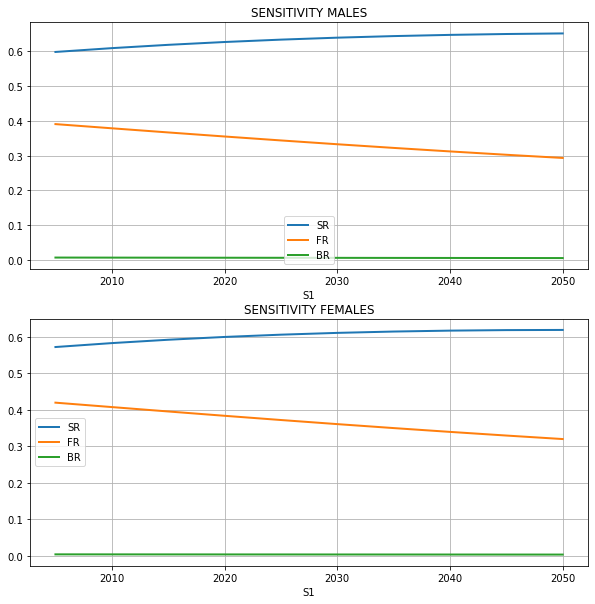

In [70]:
names = ["SR", "FR", "BR"]
problem = {
    "num_vars": len(names),
    "names": names,
    "bounds": [[SRmin, SRmax], [FRmin, FRmax], [BRmin, BRmax]]
}

popM = dataM.iloc[-1]["Total"]
popF = dataF.iloc[-1]["Total"]
param_values = saltelli.sample(problem, 1000)

years = [2005]
Si_M_results = []
Si_F_results = []

for max_steps in range(1, 11):
    years.append(years[-1] + 5)
    Y_M = EvalSensM(popM, popF, param_values, kmax=max_steps)
    Y_F = EvalSensF(popM, popF, param_values, kmax=max_steps)
    Si_M = sobol.analyze(problem, Y_M, print_to_console=False)
    Si_F = sobol.analyze(problem, Y_F, print_to_console=False)
    Si_M_results.append(Si_M)
    Si_F_results.append(Si_F)
    
Si_M_results = np.array(Si_M_results)
Si_F_results = np.array(Si_F_results)
lw = 2

tempM = np.array([item["S1"] for item in Si_M_results])
tempF = np.array([item["S1"] for item in Si_F_results])

plt.rcParams["figure.figsize"] = (10, 10)

plt.subplot(2, 1, 1)
plt.plot(years[:-1], tempM[:,0], label="SR", linewidth=lw)
plt.plot(years[:-1], tempM[:,1], label="FR", linewidth=lw)
plt.plot(years[:-1], tempM[:,2], label="BR", linewidth=lw)
plt.legend();
plt.xlabel("Year")
plt.xlabel("S1")
plt.title("SENSITIVITY MALES")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(years[:-1], tempF[:,0], label="SR", linewidth=lw)
plt.plot(years[:-1], tempF[:,1], label="FR", linewidth=lw)
plt.plot(years[:-1], tempF[:,2], label="BR", linewidth=lw)
plt.legend();
plt.xlabel("Year")
plt.xlabel("S1")
plt.title("SENSITIVITY FEMALES")
plt.grid()

plt.rcParams["figure.figsize"] = (10, 6)

## Uncertainty analysis

In [71]:
def ModelUnceM(popM, popF, SR, FR, BR, kmax=1, start_year=2005):
    males = []
    for k in range(kmax):
        popAll = popM + popF
        
        newM = popM * SR
        newM += popAll * FR * BR
        
        popM = newM
        males.append(popM)
    return np.array(males)

def ModelUnceF(popM, popF, SR, FR, BR, kmax=1, start_year=2005):
    females = []
    for k in range(kmax):
        popAll = popM + popF
        
        newF = popF * SR
        newF += popAll * FR * (1-BR)
        
        popF = newF
        females.append(popF)
    return np.array(females)

In [75]:
popM = dataM.iloc[-1]["Total"]
popF = dataF.iloc[-1]["Total"]
param_values = saltelli.sample(problem, 1000)

M_results = []
F_results = []

for p in param_values:
    M_results.append(ModelUnceM(popM, popF, p[0], p[1], p[2], kmax=9))
    F_results.append(ModelUnceF(popM, popF, p[0], p[1], p[2], kmax=9))

M_results = np.array(M_results)
F_results = np.array(F_results)
print(M_results.shape)

(8000, 9)


In [79]:
def compute_percentiles(res, intervals):
    d = {}
    for i in intervals:
        d[i] = np.percentile(res, [50-i/2,50+i/2], axis=0)
    return d    

In [95]:
dic = compute_percentiles(M_results, [50, 70, 90])
print("bottom: ", dic[50][0], "\n")
print("top: ", dic[50][1], "\n")
print("mean: ", M_results.mean(axis=0), "\n")
print(years[1:-1])

bottom:  [69086.72182201 71508.55623117 73752.46607006 75850.02203481
 77791.90607094 79570.34266389 81198.46088577 82755.8872665
 84180.66845124] 

top:  [ 76481.23905853  86703.75118052  97170.37706276 107807.44291656
 118629.19868837 129748.16013165 141030.64780758 152799.06337367
 164326.32390449] 

mean:  [ 72778.91921224  79245.50337566  85860.69054856  92639.2117145
  99596.97562829 106751.0975893  114119.94397233 121723.19166119
 129581.90180915] 

[2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050]


In [103]:
def plot_unce(years, mean_res, dic, title, color="blue", alpha=[0.4, 0.3, 0.2], lw=3):
    plt.plot(years, mean_res, linewidth=lw, label="Mean", color=color)
    i = 0
    for key in dic:
        bottom = dic[key][0]
        top = dic[key][1]
        plt.fill_between(years, bottom, top, color=color, alpha=alpha[i], label=f"{key}% interval")
        i += 1
        plt.xlabel("Year")
        plt.ylabel("Population")
        plt.grid()
        plt.legend(fontsize=18)
        plt.title(title)
    plt.show()

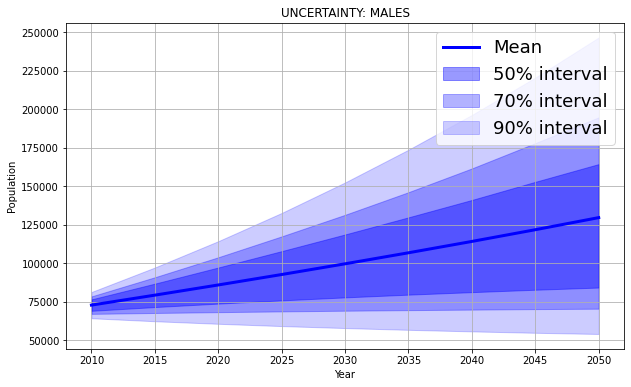

In [104]:
dic = compute_percentiles(M_results, [50, 70, 90])
plot_unce(years[1:-1], M_results.mean(axis=0), dic, "UNCERTAINTY: MALES", color="blue")

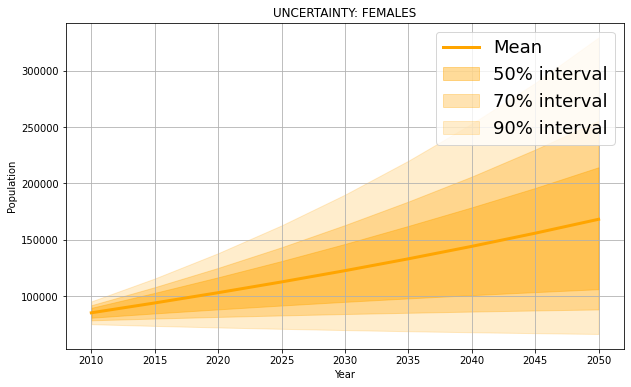

In [105]:
dic = compute_percentiles(F_results, [50, 70, 90])
plot_unce(years[1:-1], F_results.mean(axis=0), dic, "UNCERTAINTY: FEMALES", color="orange")